In [9]:
import sqlite3
import pandas as pd

# Connect to SQLite
conn = sqlite3.connect("../ecommerce.db")
cursor = conn.cursor()
# List all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(tables)

[('olist_customers_dataset',), ('olist_geolocation_dataset',), ('olist_orders_dataset',), ('olist_order_items_dataset',), ('olist_order_payments_dataset',), ('olist_order_reviews_dataset',), ('olist_products_dataset',), ('olist_sellers_dataset',), ('product_category_name_translation',)]


In [10]:
customers = pd.read_sql("SELECT * FROM olist_customers_dataset", conn)
orders = pd.read_sql("SELECT * FROM olist_orders_dataset", conn)
order_items = pd.read_sql("SELECT * FROM olist_order_items_dataset", conn)
payments = pd.read_sql("SELECT * FROM olist_order_payments_dataset", conn)
reviews = pd.read_sql("SELECT * FROM olist_order_reviews_dataset", conn)
products = pd.read_sql("SELECT * FROM olist_products_dataset", conn)
sellers = pd.read_sql("SELECT * FROM olist_sellers_dataset", conn)
geolocation = pd.read_sql("SELECT * FROM olist_geolocation_dataset", conn)
category_english = pd.read_sql("SELECT * FROM product_category_name_translation", conn)

--Revenue and Sales KPI--
What is the total revenue?
How does revenue trend monthly/quarterly?
Which states bring in the most revenue, and revenue/order vs avg revenue/order?
Which product categories bring in the most revenue?
What % of revenue comes from the top 10% of products?
What is the most ordered category in the top 10 states by revenue?

In [11]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [12]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [13]:
order_items['price'] = pd.to_numeric(order_items['price'], errors='coerce')
order_items_with_time = order_items.merge(
    orders[['order_id', 'order_purchase_timestamp']],
    on='order_id',
    how='left'
)
order_items_with_time['order_purchase_timestamp'] = pd.to_datetime(
    order_items_with_time['order_purchase_timestamp']
)
order_items_with_time['order_month'] = (
    order_items_with_time['order_purchase_timestamp']
    .dt.to_period('M')
)
monthly_revenue = (
    order_items_with_time
    .groupby('order_month')['price']
    .sum()
    .reset_index(name='total_revenue')
)

monthly_revenue['order_month'] = (
    monthly_revenue['order_month']
    .dt.to_timestamp()
)

In [14]:
total_revenue = monthly_revenue['total_revenue'].sum()
print(total_revenue)

13591643.7


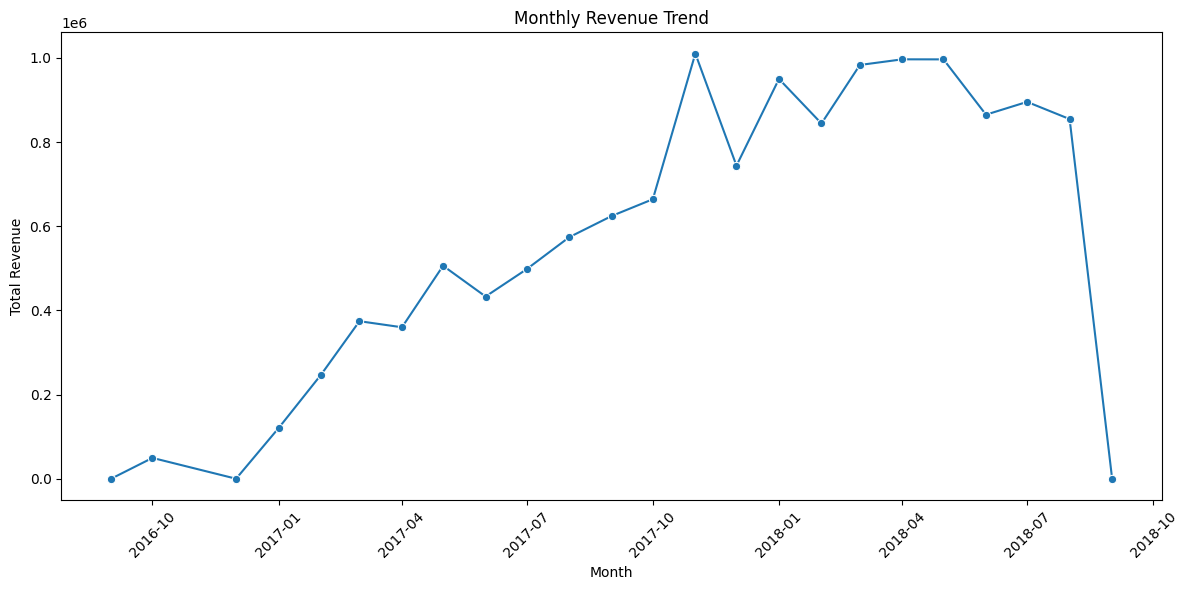

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_revenue,
    x='order_month',
    y='total_revenue',
    marker='o'
)

plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Q: What is the total revenue?
Q: How does revenue trend monthly
A: The total revenue over the entire period is $13.6M, with a steady increase from Oct 2016 to Nov 2017, averaging ~$0.6M, and continues to hover around $0.8M/month thereafter

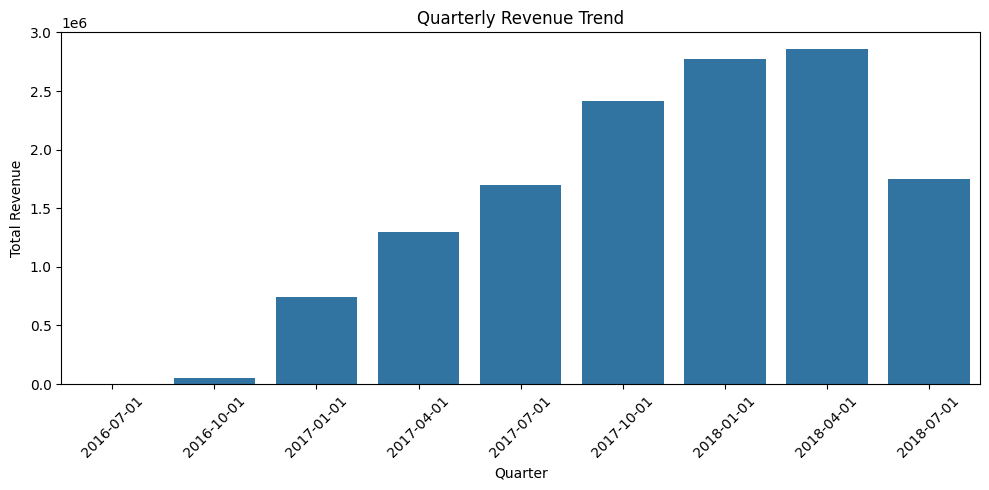

In [16]:
# Add order_quarter column
order_items_with_time['order_quarter'] = order_items_with_time['order_purchase_timestamp'].dt.to_period('Q')

# Aggregate total revenue by quarter
quarterly_revenue = (
    order_items_with_time
    .groupby('order_quarter')['price']
    .sum()
    .reset_index(name='total_revenue')
)

# Convert period to timestamp if needed for plotting
quarterly_revenue['order_quarter_start'] = quarterly_revenue['order_quarter'].dt.start_time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(
    data=quarterly_revenue,
    x='order_quarter_start',
    y='total_revenue',
)
plt.title("Quarterly Revenue Trend")
plt.xlabel("Quarter")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Q: How does revenue trend quarterly?
A: There is no noticable seasonal trend, but revenue has been steadily increasing by ~$0.4M per quarter, with the exception of 2018 Q3, which shows a temporary drop, likely due to incomplete data.

In [17]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [18]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [19]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [20]:
orders_by_state = orders.merge(
    customers[['customer_id', 'customer_state']],
    on='customer_id',
    how='left'
)
orders_by_state_price = orders_by_state.merge(
    order_items[['order_id', 'price']],
    on='order_id',
    how='left'
)
# Group by state and aggregate both metrics
state_summary = (
    orders_by_state_price
    .groupby('customer_state')
    .agg(
        num_orders=('order_id', 'nunique'),  # count unique orders
        total_revenue=('price', 'sum')       # sum of price
    )
    .reset_index()
)
state_summary['revenue/order'] = state_summary['total_revenue']/state_summary['num_orders']
state_summary.head()

,customer_state,num_orders,total_revenue,revenue/order
0,AC,81,15982.95,197.320370
1,AL,413,80314.81,194.466852
2,AM,148,22356.84,151.059730
3,AP,68,13474.30,198.151471
4,BA,3380,511349.99,151.286979


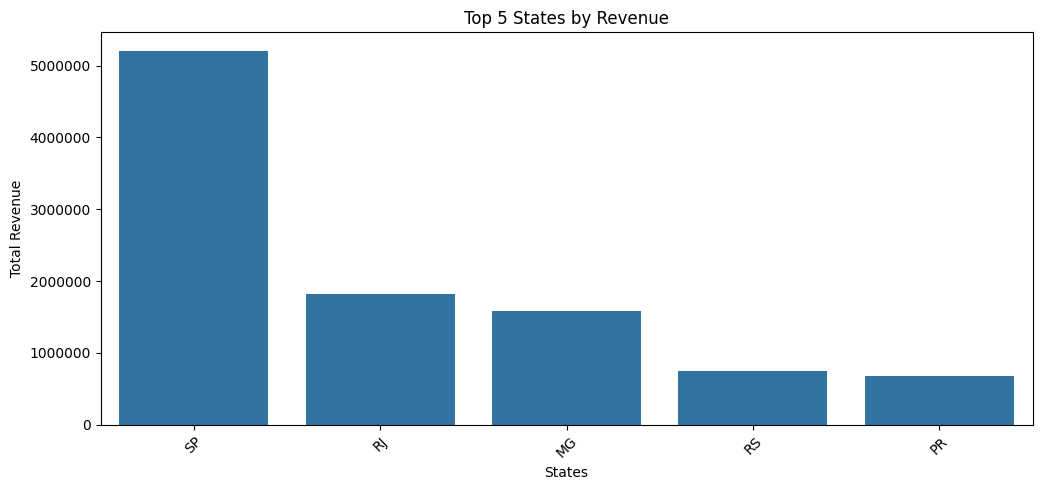

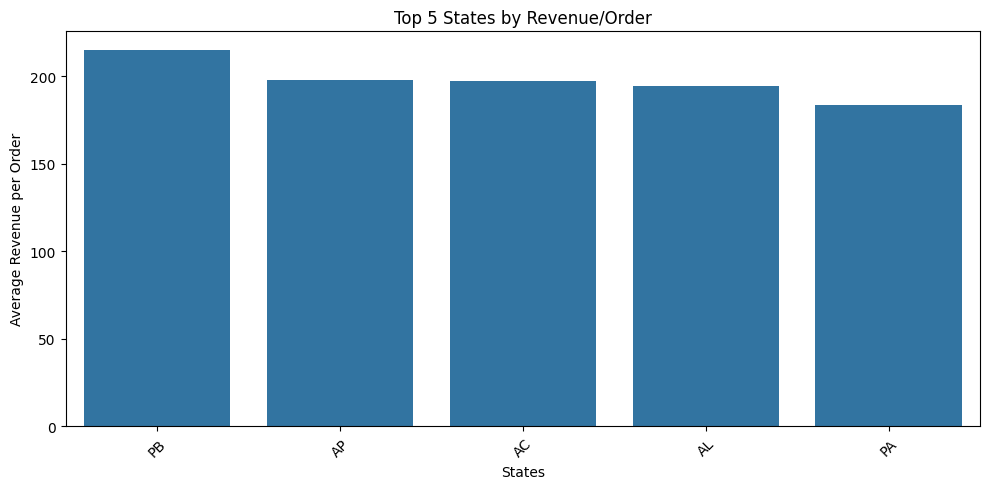

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(
    data=state_summary.sort_values(by='total_revenue', ascending=False).head(5), #Top 5 state by total revenue
    x='customer_state',
    y='total_revenue',
)
plt.title("Top 5 States by Revenue")
plt.xlabel("States")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(
    data=state_summary.sort_values(by='revenue/order', ascending=False).head(5), #Top 5 state by total revenue
    x='customer_state',
    y='revenue/order',
)
plt.title("Top 5 States by Revenue/Order")
plt.xlabel("States")
plt.ylabel("Average Revenue per Order")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# Sum total revenue and total orders across all states
total_revenue = state_summary['total_revenue'].sum()
total_orders = state_summary['num_orders'].sum()

# Compute average revenue per order
avg_revenue_per_order = total_revenue / total_orders

print(f"Average revenue per order: ${avg_revenue_per_order:,.2f}")

Average revenue per order: $136.68


Q: Which states bring in the most revenue?
A: SP brings in the most revenue at ~$5M, followed by RJ at ~$1.7M and MG at ~$1.5M.
Q: Which states bring in the most revenue/order?
A: PB brings in the most revenue/order at ~$210, followed by AP at ~$200 with AC close behind.
Q: What is the avg revenue/order?
A: The average revenue per order is $136.68 across all purchases.

In [23]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [24]:
products.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [25]:
category_english.columns

Index(['product_category_name', 'product_category_name_english'], dtype='object')

In [26]:
category_revenue = order_items.merge(
    products[['product_id', 'product_category_name']],
    on='product_id',
    how='left'
)
category_revenue_english = category_revenue.merge(
    category_english[['product_category_name','product_category_name_english']],
    on='product_category_name',
    how='left'
)
category_revenue_summary = (
    category_revenue_english
    .groupby('product_category_name_english')
    .agg(
        num_orders=('order_id', 'nunique'),  # count unique orders
        total_revenue=('price', 'sum')       # sum of price
    )
    .reset_index()
)
category_revenue_summary.head()

,product_category_name_english,num_orders,total_revenue
0,agro_industry_and_commerce,182,72530.47
1,air_conditioning,253,55024.96
2,art,202,24202.64
3,arts_and_craftmanship,23,1814.01
4,audio,350,50688.50


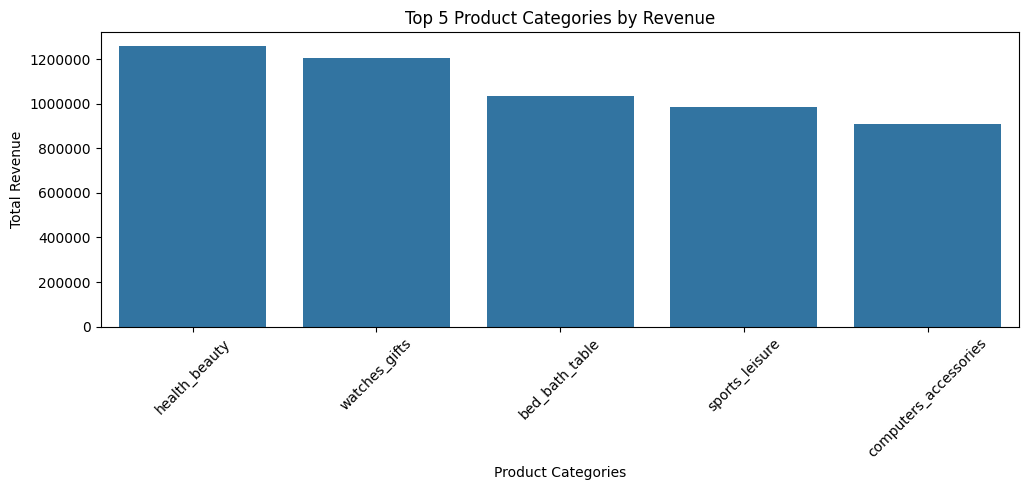

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(
    category_revenue_summary.sort_values(by='total_revenue', ascending=False).head(5), #Top 5 state by total revenue
    x='product_category_name_english',
    y='total_revenue',
)
plt.title("Top 5 Product Categories by Revenue")
plt.xlabel("Product Categories")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

Q: Which product categories bring in the most revenue?
A: Health and Beauty brings in the most at ~$1.22M, followed by Watches and Gifts at ~$1.2M and Bed, Bath, Table at ~$1M

In [28]:
import math
order_item_summary = (
    order_items
    .groupby('product_id')
    .agg(
        num_orders=('order_id', 'nunique'),  # count unique orders
        total_revenue=('price', 'sum')       # sum of price
    )
    .reset_index()
)
top_10_percent = math.floor(len(order_item_summary) * 0.1)
order_item_summary_top_10 = order_item_summary.sort_values(by='total_revenue', ascending=False).head(top_10_percent)
total_top10_revenue_percent = order_item_summary_top_10['total_revenue'].sum()/total_revenue*100
order_item_summary_top_10.head(5)

,product_id,num_orders,total_revenue
24086,bb50f2e236e5eea0100680137654686c,187,63885.00
14068,6cdd53843498f92890544667809f1595,151,54730.20
27613,d6160fb7873f184099d9bc95e30376af,35,48899.34
27039,d1c427060a0f73f6b889a5c7c61f2ac4,323,47214.51
19742,99a4788cb24856965c36a24e339b6058,467,43025.56


In [29]:
print(total_top10_revenue_percent)

60.839627733914185


Q: What % of revenue comes from the top 10% of products?
A: 61% of revenue comes from the top 10% of products, with product_id bb50f2e236e5eea0100680137654686c contributing the most, $63.9k. (No product name available)

In [30]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [31]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [32]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [33]:
top_10_states = state_summary.sort_values('total_revenue', ascending=False).head(10)
orders_top_states = orders.merge(
    customers[['customer_id','customer_state']], 
    on='customer_id', 
    how='left'
)
orders_top_states = orders_top_states[orders_top_states['customer_state'].isin(top_10_states['customer_state'])]

In [34]:
orders_items_top = orders_top_states.merge(
    order_items[['order_id','product_id']], 
    on='order_id', 
    how='left'
).merge(
    products[['product_id','product_category_name']], 
    on='product_id', 
    how='left'
)

In [37]:
orders_items_top.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_state', 'product_id', 'product_category_name'],
      dtype='object')

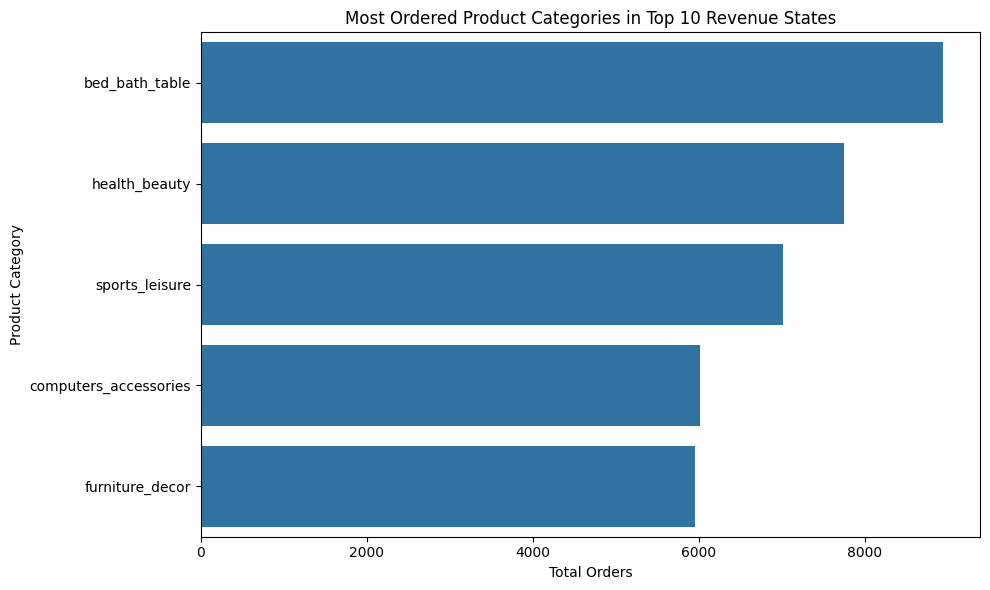

In [ ]:
category_order_sums = (
    orders_items_top
    .groupby('product_category_name')['order_id']
    .nunique()  # COUNTD(Order ID)
    .reset_index(name='total_num_orders')
    .sort_values(by='total_num_orders', ascending=False)
)

#English names
category_order_sums = category_order_sums.merge(
    category_english[['product_category_name','product_category_name_english']],
    on='product_category_name',
    how='left'
).sort_values(by='total_num_orders', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the top categories by total orders
plt.figure(figsize=(10,6))
sns.barplot(
    data=category_order_sums.head(5),        
    x='total_num_orders',              # Total orders
    y='product_category_name_english',# Category names
)

plt.title("Most Ordered Product Categories in Top 10 Revenue States")
plt.xlabel("Total Orders")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

Q: What is the most ordered category in the top 10 states by revenue?
A: Across the top 10 states, Bed,Bath and Table is the most ordered at 8.5k orders, followed by Health and Beauty, and Sports and Leisure at ~7.8k and ~7k respectively.

--Customer KPIs--
How many unique customers are there?
Which states have the highest customer concentration?
What % of customers are repeat buyers?
Do repeat buyers spend more than one-time buyers?
What is the average time between each purchase?

In [ ]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [ ]:
customers_by_state = (
    customers
    .groupby('customer_state')['customer_id']
    .nunique()
    .reset_index(name='num_unique_customers')
)
customers_by_state.sort_values('num_unique_customers', ascending=False).head()

,customer_state,num_unique_customers
25,SP,41746
18,RJ,12852
10,MG,11635
22,RS,5466
17,PR,5045


In [ ]:
total_customers = customers['customer_id'].nunique()
total_customers

99441

Q: How many unique customers are there?
Q: Which states have the highest customer concentration?
A: There are 99.4k unique customers, with largest share of 41.7k from SP.

In [ ]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [ ]:
orders_per_customer  = orders.merge(
    customers[['customer_id','customer_unique_id']], 
    on='customer_id', 
    how='left'
).groupby('customer_unique_id'
          ).size().reset_index(name='num_orders')

orders_per_customer.sort_values('num_orders', ascending=False).head()

,customer_unique_id,num_orders
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7


In [ ]:
repeat_customers_count = orders_per_customer[orders_per_customer['num_orders'] > 1].shape[0]
repeat_customers_count/total_customers*100

3.0138474070051586

Q: What % of customers are repeat buyers?
A: 3% of customers are repeat buyers

In [ ]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [ ]:
orders_per_customer = orders.merge(
    customers[['customer_id','customer_unique_id']], on='customer_id', how='left' 
    ).merge( order_items[['order_id','price']]
            , on='order_id', how='left' )

customer_summary = (
    orders_per_customer
    .groupby('customer_unique_id')
    .agg(
        num_orders=('order_id', 'nunique'),
        total_revenue=('price', 'sum')
    )
    .reset_index()
)

customer_summary.head()

,customer_unique_id,num_orders,total_revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90
2,0000f46a3911fa3c0805444483337064,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,180.00


In [ ]:
one_time_customers = customer_summary[customer_summary['num_orders'] == 1]
repeat_customers = customer_summary[customer_summary['num_orders'] > 1]
repeat_revenue = repeat_customers['total_revenue'].sum()
total_revenue = customer_summary['total_revenue'].sum()

repeat_revenue_share = repeat_revenue / total_revenue * 100
repeat_revenue_share
one_time_customers['total_revenue'].mean()

np.float64(137.62577181280142)

In [ ]:
repeat_customers['total_revenue'].mean()

np.float64(259.8671905238572)

Q: Do repeat buyers spend more than one-time buyers?
A: Repeat buyers have a higher average spend per order, at $259.87 per order compared to one-time buyers at $137.63

In [ ]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [ ]:
orders_per_customer = orders.merge(
    customers[['customer_id','customer_unique_id']], on='customer_id', how='left' 
    )
# Sort by customer and timestamp
orders_sorted = orders_per_customer.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
# Convert to Date Time for Calculation
orders_sorted['order_purchase_timestamp'] = pd.to_datetime(orders_sorted['order_purchase_timestamp'])
# Compute difference per customer
orders_sorted['time_diff'] = orders_sorted.groupby('customer_unique_id')['order_purchase_timestamp'].diff()

# Drop NaT (first order for each customer)
time_diffs = orders_sorted['time_diff'].dropna()

# Average in days
average_days = time_diffs.mean().total_seconds() / (60*60*24)
print(f"Average time between purchases per customer: {average_days:.2f} days")


Average time between purchases per customer: 78.23 days


Q: What is the average time between each purchase?
A: The average time between each purchase is approximately 78 days, for repeat customers.

In [ ]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [ ]:
order_time = orders.copy()
order_time['order_purchase_timestamp'] = pd.to_datetime(order_time['order_purchase_timestamp'])
order_time['order_delivered_customer_date'] = pd.to_datetime(order_time['order_delivered_customer_date'])
order_time['order_estimated_delivery_date'] = pd.to_datetime(order_time['order_estimated_delivery_date'])

In [ ]:
delivered_orders = order_time[order_time['order_status'] == 'delivered'].copy()
delivered_orders['delivery_time'] = delivered_orders['order_delivered_customer_date'] - delivered_orders['order_purchase_timestamp']
delivered_orders['delivery_time'].describe()

count                         96470
mean     12 days 13:23:49.957271690
std       9 days 13:06:27.911052929
min                 0 days 12:48:07
25%                 6 days 18:23:20
50%                10 days 05:13:10
75%         15 days 17:17:03.750000
max               209 days 15:05:12
Name: delivery_time, dtype: object

In [ ]:
delivered_orders['delivery_days'] = delivered_orders['delivery_time'].dt.total_seconds() / (24*3600)
delivered_orders['delivery_days_rounded'] = delivered_orders['delivery_days'].round()
delivered_orders['delivery_days_rounded'].mode()

0    7.0
Name: delivery_days_rounded, dtype: float64

--Delivery & Operations--
Q: What is the average delivery time?
A: The average delivery time is 12-13 days, with most orders being delivered in 7 days

In [ ]:
delivered_orders['order_delivered_customer_date'] = pd.to_datetime(
    delivered_orders['order_delivered_customer_date']
)
delivered_orders['delivery_delay'] = delivered_orders['order_delivered_customer_date'] - delivered_orders['order_estimated_delivery_date'] 
delivered_orders['delivery_delay'].describe()

count                           96470
mean     -12 days +02:58:43.200995128
std        10 days 04:22:13.878393156
min               -147 days +00:00:00
25%                -17 days +00:00:00
50%                -12 days +00:00:00
75%                 -7 days +00:00:00
max                 188 days 00:00:00
Name: delivery_delay, dtype: object

In [ ]:
delivered_orders['delivery_category'] = 'On time'  # default
delivered_orders['delivery_delay_days'] = delivered_orders['delivery_delay'].dt.days
delivered_orders.loc[delivered_orders['delivery_delay_days'] < 0, 'delivery_category'] = 'Early'
delivered_orders.loc[delivered_orders['delivery_delay_days'] > 0, 'delivery_category'] = 'Late'
# Count per category
counts = delivered_orders.groupby('delivery_category')['delivery_category'].count()

# Percentage per category
percentages = delivered_orders.groupby('delivery_category')['delivery_category'].count() / len(delivered_orders) * 100
print(percentages)


delivery_category
Early      88644
Late        6534
On time     1300
Name: delivery_category, dtype: int64
delivery_category
Early      91.880014
Late        6.772528
On time     1.347457
Name: delivery_category, dtype: float64


Q: What % of orders are delivered on time / early / late?
A: 92% of the orderes are early, with 7% being late, and 1% on time.

In [ ]:
late_orders = delivered_orders[delivered_orders['delivery_category'] == 'Late']
late_orders['delivery_delay_days'].describe()

count    6534.000000
mean       10.620141
std        14.644955
min         1.000000
25%         3.000000
50%         7.000000
75%        13.000000
max       188.000000
Name: delivery_delay_days, dtype: float64

In [ ]:
late_orders['delivery_delay_days'].mode()

0    1.0
Name: delivery_delay_days, dtype: float64

Q: How late are late deliveries?
A: Late deliveries are 10 days late on average, but most commonly 1 day late.

In [ ]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [ ]:
late_orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'delivery_time', 'delivery_days', 'delivery_days_rounded',
       'delivery_delay', 'delivery_category', 'delivery_delay_days'],
      dtype='object')

In [ ]:
state_delay = late_orders.merge(
    customers[['customer_id', 'customer_state']], 
on='customer_id', 
how='left')
# 2️⃣ Calculate 99th percentile of delivery_delay_days
p99 = state_delay['delivery_delay_days'].quantile(0.99)

# 3️⃣ Filter out extreme delays
state_delay_clean = state_delay[state_delay['delivery_delay_days'] <= p99].copy()

# 4️⃣ Group by state and calculate mean delay
state_summary = (
    state_delay_clean.groupby('customer_state')['delivery_delay_days']
    .mean()
    .reset_index()
    .rename(columns={'delivery_delay_days': 'mean_delay_days'})
)

In [ ]:
# 5️⃣ Sort descending
state_summary.sort_values('mean_delay_days', ascending=False).head()

,customer_state,mean_delay_days
0,AC,18.666667
5,CE,13.624277
18,RJ,12.817262
21,RR,12.500000
19,RN,11.627907


Q: Which state sees the worst delays?
A: AP sees the worst delay at 18.6 days

In [ ]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [ ]:
reviews.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [ ]:
#Change Orders dataframe to datetime
order_time = orders.copy()
order_time['order_purchase_timestamp'] = pd.to_datetime(order_time['order_purchase_timestamp'])
order_time['order_delivered_customer_date'] = pd.to_datetime(order_time['order_delivered_customer_date'])
order_time['order_estimated_delivery_date'] = pd.to_datetime(order_time['order_estimated_delivery_date'])

#Filter for Delivered orders and calculate delivery time
delivered_orders = order_time[order_time['order_status'] == 'delivered'].copy()

#Sort for Late Orders
delivered_orders['delivery_category'] = 'On time'  # default
delivered_orders['delivery_delay'] = delivered_orders['order_delivered_customer_date'] - delivered_orders['order_estimated_delivery_date']
delivered_orders['delivery_delay_days'] = delivered_orders['delivery_delay'].dt.days
delivered_orders.loc[delivered_orders['delivery_delay_days'] < 0, 'delivery_category'] = 'Early'
delivered_orders.loc[delivered_orders['delivery_delay_days'] > 0, 'delivery_category'] = 'Late'
late_orders = delivered_orders[delivered_orders['delivery_category'] == 'Late']

In [ ]:
late_orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'delivery_category', 'delivery_delay', 'delivery_delay_days'],
      dtype='object')

In [ ]:
reviews.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [ ]:
order_delay_review = late_orders.merge(
    reviews[['order_id', 'review_score']],
    on='order_id',
    how='left'
)

In [ ]:
order_delay_review.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'delivery_category', 'delivery_delay', 'delivery_delay_days',
       'review_score'],
      dtype='object')

In [ ]:
order_delay_review_relationship = (
    order_delay_review.groupby('review_score')['delivery_delay_days']
    .mean()
    .reset_index()
)

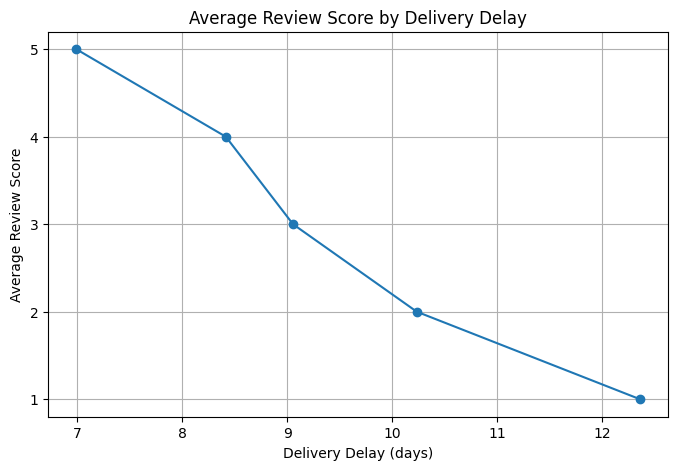

In [ ]:
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(8,5))
plt.plot(order_delay_review_relationship['delivery_delay_days'], order_delay_review_relationship['review_score'], marker='o')
plt.xlabel('Delivery Delay (days)')
plt.ylabel('Average Review Score')
plt.title('Average Review Score by Delivery Delay')
plt.grid(True)
plt.show()


Q: Is there any relationship between delivery delay and review scores?
A: The higher the average review score, the lower the average delivery delay days for the order, showing a inverse relationship.This indicates that delivery timeliness has a measurable impact on customer satisfaction.

--Customer Satisfaction--
What is the average review score?
Does late delivery reduce review scores?
Do certain categories get systematically worse reviews?
Does faster review response time improve ratings?

--Product & Category Performance--
Which products sell the most units?
Which categories have high volume but low revenue?
What % of products generate 80% of sales?

--Payment & Risk--
What payment methods are most common?
Do certain payment methods have higher order values?
Do installment orders get worse reviews?
Does payment type affect delivery speed?

Revenue & Product
Delivery & Operations
Customer Satisfaction